✅ Using device: cpu
📁 Total Classes: 102
✅ Model ready.

🚀 Training started...



100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [03:08<00:00,  1.51it/s]


Epoch [1/5] Train Loss: 3.0534 | Val Loss: 1.6332 | Val Acc: 59.88%


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:06<00:00,  2.25it/s]


Epoch [2/5] Train Loss: 1.7098 | Val Loss: 0.9479 | Val Acc: 73.62%


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [01:59<00:00,  2.37it/s]


Epoch [3/5] Train Loss: 1.2435 | Val Loss: 0.7143 | Val Acc: 78.67%


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [01:29<00:00,  3.16it/s]


Epoch [4/5] Train Loss: 1.0622 | Val Loss: 0.6076 | Val Acc: 81.30%


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [01:26<00:00,  3.28it/s]


Epoch [5/5] Train Loss: 0.9084 | Val Loss: 0.5539 | Val Acc: 83.58%

✅ Training complete. Best model saved as 'best_model.pth'


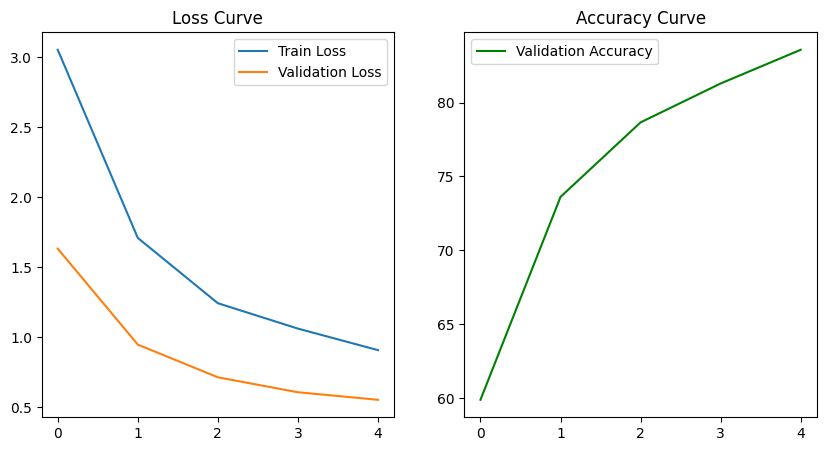


📊 Final Validation Accuracy: 83.58%


In [1]:
# =============================
# 🔹 Assignment 6 - Transfer Learning (Caltech101)
# =============================

import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# =============================
# 1. Device setup
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# =============================
# 2. Paths (adjust if needed)
# =============================
data_dir = "dataset"  # Folder containing train/valid/test
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir  = os.path.join(data_dir, "test")

# =============================
# 3. Transforms
# =============================
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224), # Imagenet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# =============================
# 4. Load dataset and create loaders
# =============================
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid'])
}

batch_size = 16

dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True)
}

class_names = data['train'].classes
n_classes = len(class_names)
print(f"📁 Total Classes: {n_classes}")

# =============================
# 5. Load Pretrained Model
# =============================

# ✅ Option 1 (Recommended for low RAM)
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# ✅ Option 2 (If running on Colab / high RAM)
# from torchvision.models import vgg16, VGG16_Weights
# model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# =============================
# 6. Add custom classifier
# =============================
if hasattr(model, 'fc'):   # ResNet18
    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(n_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, n_classes),
        nn.LogSoftmax(dim=1)
    )
else:  # VGG16
    n_inputs = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Linear(n_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, n_classes),
        nn.LogSoftmax(dim=1)
    )

model = model.to(device)
print("✅ Model ready.")

# =============================
# 7. Define Loss & Optimizer
# =============================
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =============================
# 8. Training Loop with Validation
# =============================
n_epochs = 5
train_losses, val_losses, val_accuracies = [], [], []
best_val_loss = float('inf')
patience, trigger_times = 2, 0

print("\n🚀 Training started...\n")

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloaders['train']):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(dataloaders['train']))
    val_losses.append(val_loss / len(dataloaders['valid']))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{n_epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Val Acc: {val_accuracy:.2f}%")

    # Early Stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("⏹️ Early stopping triggered!")
            break

print("\n✅ Training complete. Best model saved as 'best_model.pth'")

# =============================
# 9. Plot Performance
# =============================
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Validation Accuracy", color='green')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# =============================
# 10. Evaluate on Validation Set
# =============================
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in dataloaders['valid']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"\n📊 Final Validation Accuracy: {100 * correct / total:.2f}%")
